# Text Processing - Yelp 2021

## Imports and Global Settings

In [50]:
# Common Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Main NLP libraries
import nltk
# Wordclouds
from wordcloud import WordCloud, STOPWORDS
# Reading Level and Basic Stats
import textstat
from nltk.corpus import stopwords as nltk_stopwords
# Sentiment Analysis
from textblob import TextBlob
# Parts of Speech, Named Entities, Syntactic Dependencies
import spacy
# Classification
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB


pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Import Data

In [2]:
file_location = "../data/full_data/analytics_ready/"
filename = "text_data.json"

In [3]:
# 6907890 records available
num_records_to_load = 10000

In [4]:
df = pd.read_json(file_location + filename, nrows=num_records_to_load, orient="records", lines=True)

## Pre-Processing

In [5]:
df.head(5)

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         10000 non-null  object
 1   review_stars      10000 non-null  int64 
 2   review_text       10000 non-null  object
 3   target_ufc_bool   10000 non-null  object
 4   target_ufc_count  10000 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 390.8+ KB


In [7]:
df.target_ufc_bool.value_counts()

True     5134
False    4866
Name: target_ufc_bool, dtype: int64

## Splitting Text

In [8]:
corpus = df.review_text
Q_corpus = df[df["target_ufc_bool"] == "True"]["review_text"]
NQ_corpus = df[df["target_ufc_bool"] == "False"]["review_text"]
print(f'Corpus Size: Total:{corpus.size}, Quality:{Q_corpus.size}, Not Quality:{NQ_corpus.size}')

Corpus Size: Total:10000, Quality:5134, Not Quality:4866


## WordClouds

### Wordcloud Stopwords

In [9]:
stopwords = set(STOPWORDS)
stopwords.update([])

#### Join Corpus Into One String

In [10]:
Q_text = " ".join(review for review in Q_corpus)
NQ_text = " ".join(review for review in NQ_corpus)

### Make Wordclouds

In [11]:
Q_wordcloud = WordCloud(stopwords=stopwords, background_color="cornflowerblue", colormap="Set1",
                      collocations=False, color_func=lambda *args, **kwargs: "black",
                      width=1000, height=1000).generate(Q_text)

In [12]:
NQ_wordcloud = WordCloud(stopwords=stopwords, background_color="lightcoral", colormap="Set1",
                      collocations=False, color_func=lambda *args, **kwargs: "black",
                      width=1000, height=1000).generate(NQ_text)

### Save and Show Wordclouds

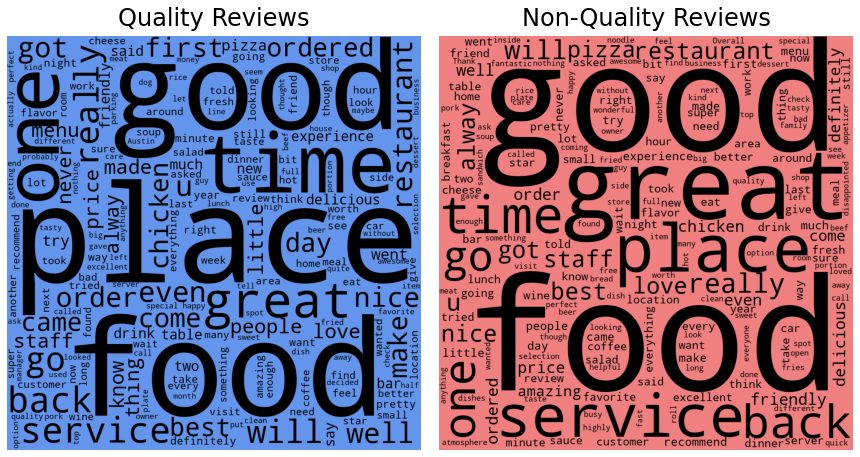

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.imshow(Q_wordcloud)
ax1.axis("off")
ax1.set_title("Quality Reviews", fontsize=24, pad=10)


ax2.imshow(NQ_wordcloud)
ax2.axis("off")
ax2.set_title("Non-Quality Reviews", fontsize=24, pad=10)

fig.tight_layout(pad=0)

# plt.savefig('../images/review_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

## Basic Info

In [14]:
text = df.copy()

#### Feature Creation Stopwords

In [15]:
feature_stopwords = nltk_stopwords.words('english')

In [16]:
text['word_count'] = text['review_text'].apply(lambda x: len(str(x).split(" ")))
text['character_count'] = text['review_text'].str.len()

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

text['avg_word_length'] = text['review_text'].apply(lambda x: avg_word(x))
text['num_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
text['uppercase_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
text['#_@_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.startswith('#') or x.startswith('@')]))
text['stopword_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x in feature_stopwords]))

In [17]:
text["sentence_count"] = text["review_text"].apply(textstat.sentence_count)
text["lexicon_count"] = text["review_text"].apply(textstat.lexicon_count)
text["syllable_count"] = text["review_text"].apply(textstat.syllable_count)

In [18]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         10000 non-null  object 
 1   review_stars      10000 non-null  int64  
 2   review_text       10000 non-null  object 
 3   target_ufc_bool   10000 non-null  object 
 4   target_ufc_count  10000 non-null  int64  
 5   word_count        10000 non-null  int64  
 6   character_count   10000 non-null  int64  
 7   avg_word_length   10000 non-null  float64
 8   num_count         10000 non-null  int64  
 9   uppercase_count   10000 non-null  int64  
 10  #_@_count         10000 non-null  int64  
 11  stopword_count    10000 non-null  int64  
 12  sentence_count    10000 non-null  int64  
 13  lexicon_count     10000 non-null  int64  
 14  syllable_count    10000 non-null  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 1.1+ MB


,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,stopword_count,sentence_count,lexicon_count,syllable_count
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,12,3,37,47
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,39,6,98,138
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,20,4,44,62
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,52,1,110,143
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,6,3,19,24


## Reading Level

In [19]:
text["grade_level"] = text["review_text"].apply(textstat.flesch_kincaid_grade)

In [20]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         10000 non-null  object 
 1   review_stars      10000 non-null  int64  
 2   review_text       10000 non-null  object 
 3   target_ufc_bool   10000 non-null  object 
 4   target_ufc_count  10000 non-null  int64  
 5   word_count        10000 non-null  int64  
 6   character_count   10000 non-null  int64  
 7   avg_word_length   10000 non-null  float64
 8   num_count         10000 non-null  int64  
 9   uppercase_count   10000 non-null  int64  
 10  #_@_count         10000 non-null  int64  
 11  stopword_count    10000 non-null  int64  
 12  sentence_count    10000 non-null  int64  
 13  lexicon_count     10000 non-null  int64  
 14  syllable_count    10000 non-null  int64  
 15  grade_level       10000 non-null  float64
dtypes: float64(2), int64(11), object(3)
memor

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,stopword_count,sentence_count,lexicon_count,syllable_count,grade_level
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,12,3,37,47,4.50000
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,39,6,98,138,7.30000
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,20,4,44,62,5.20000
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,52,1,110,143,42.70000
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,6,3,19,24,2.20000


## Sentiment Analysis

In [21]:
text["polarity"] = text["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
text["subjectivity"] = text["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [22]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         10000 non-null  object 
 1   review_stars      10000 non-null  int64  
 2   review_text       10000 non-null  object 
 3   target_ufc_bool   10000 non-null  object 
 4   target_ufc_count  10000 non-null  int64  
 5   word_count        10000 non-null  int64  
 6   character_count   10000 non-null  int64  
 7   avg_word_length   10000 non-null  float64
 8   num_count         10000 non-null  int64  
 9   uppercase_count   10000 non-null  int64  
 10  #_@_count         10000 non-null  int64  
 11  stopword_count    10000 non-null  int64  
 12  sentence_count    10000 non-null  int64  
 13  lexicon_count     10000 non-null  int64  
 14  syllable_count    10000 non-null  int64  
 15  grade_level       10000 non-null  float64
 16  polarity          10000 non-null  float64

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,stopword_count,sentence_count,lexicon_count,syllable_count,grade_level,polarity,subjectivity
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,12,3,37,47,4.50000,0.45333,0.54333
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,39,6,98,138,7.30000,0.16399,0.51190
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,20,4,44,62,5.20000,0.47396,0.55833
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,52,1,110,143,42.70000,0.23874,0.61131
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,6,3,19,24,2.20000,0.40000,0.85000


## Linguistic Components with Spacy

In [47]:
pos_list = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "DET", "INTJ", "NOUN", "NUM",
            "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X",]
dep_list = ["ROOT", "acl", "acomp", "advcl", "advmod", "agent", "amod",
            "appos", "attr", "aux", "auxpass", "case", "cc", "ccomp",
            "compound", "conj", "csubj", "csubjpass", "dative", "dep", "det",
            "dobj", "expl", "intj", "mark", "meta", "neg", "nmod", "npadvmod",
            "nsubj", "nsubjpass", "nummod", "oprd", "parataxis", "pcomp",
            "pobj", "poss", "preconj", "predet", "prep", "prt", "punct",
            "quantmod", "relcl","xcomp"]
ent_list = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
            "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", "PERSON",
            "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]

In [48]:
def create_spacy_features(df, text_feature_name):
    """
    Adds various features using Spacy's library and NLP models.

    Key Terms:
        pos_dict: Part of Speech
                  https://universaldependencies.org/u/pos/

        dep_list: Universal Dependency Relations
                  https://universaldependencies.org/u/dep/

        ent_list: Named Entity
                  https://spacy.io/api/annotation#named-entities
    """
    nlp = spacy.load("en_core_web_sm")

    df["spacy_doc"] = df[text_feature_name].apply(lambda x: nlp(x))
    df["spacy_token_count"] = df["spacy_doc"].apply(lambda x: len(x))
    df["spacy_perc_stop_words"] = df["spacy_doc"].apply(lambda x: round(len([token for token in x if token.is_stop]) / len(x), 5))
    df["spacy_perc_ent"] = df["spacy_doc"].apply(lambda x: round(len([token for token in x.ents]) / len(x), 5))

    for pos in pos_list:
        df[f"spacy_perc_{pos.lower()}"] = df["spacy_doc"].apply(
            lambda x: round(len([token for token in x if token.pos_ == pos]) / len(x), 2))

    for dep in dep_list:
        df[f"spacy_perc_{dep.lower()}"] = df["spacy_doc"].apply(
            lambda x: round(len([token for token in x if token.dep_ == dep]) / len(x), 2))
    
    for ent in ent_list:
        df[f"spacy_perc_{ent.lower()}"] = df["spacy_doc"].apply(
            lambda x: round(len([y for y in x.ents if y.label_ == ent]) / len(x), 2))
    
    df.drop("spacy_doc", axis=1, inplace=True)
    
    return df

In [51]:
text = create_spacy_features(text, 'review_text')

In [52]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 96 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   review_id               10000 non-null  object 
 1   review_stars            10000 non-null  int64  
 2   review_text             10000 non-null  object 
 3   target_ufc_bool         10000 non-null  object 
 4   target_ufc_count        10000 non-null  int64  
 5   word_count              10000 non-null  int64  
 6   character_count         10000 non-null  int64  
 7   avg_word_length         10000 non-null  float64
 8   num_count               10000 non-null  int64  
 9   uppercase_count         10000 non-null  int64  
 10  #_@_count               10000 non-null  int64  
 11  stopword_count          10000 non-null  int64  
 12  sentence_count          10000 non-null  int64  
 13  lexicon_count           10000 non-null  int64  
 14  syllable_count          10000 non-null 

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,...,spacy_perc_money,spacy_perc_norp,spacy_perc_ordinal,spacy_perc_org,spacy_perc_percent,spacy_perc_person,spacy_perc_product,spacy_perc_quantity,spacy_perc_time,spacy_perc_work_of_art
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,...,0.00000,0.05000,0.02000,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.00000
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,...,0.00000,0.00000,0.01000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,...,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Classification Using Classical Machine Learning and Text Vectorization - Tf-Idf

In [23]:
baseline_cls_data = df[['review_text', 'target_ufc_bool']]
baseline_cls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_text      10000 non-null  object
 1   target_ufc_bool  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [24]:
X = baseline_cls_data.review_text
y = baseline_cls_data.target_ufc_bool

In [25]:
scoring = {'roc_auc': 'roc_auc',
           'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, pos_label="True"),
           'recall': make_scorer(recall_score, pos_label="True")}

In [26]:
def display_clf_results(cv_clf):
    print('Model Performance')
    print(f'Fit Time: {np.mean(cv_clf["fit_time"]):.2f} secs, Score Time: {np.mean(cv_clf["score_time"]):.2f} secs')
    print(f'Accuracy: {np.mean(cv_clf["test_accuracy"]):.2f}')
    print(f'ROC AUC: {np.mean(cv_clf["test_roc_auc"]):.2f}')
    print(f'Precision: {np.mean(cv_clf["test_precision"]):.2f}')
    print(f'Recall: {np.mean(cv_clf["test_recall"]):.2f}')

### Word Count Baseline

In [27]:
word_count_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

In [28]:
wc_results = cross_validate(word_count_pipeline, X, y, cv=5, scoring=scoring)

In [29]:
display_clf_results(wc_results)

Model Performance
Fit Time: 1.00 secs, Score Time: 0.45 secs
Accuracy: 0.61
ROC AUC: 0.65
Precision: 0.63
Recall: 0.60


### Tf-idf Baseline

In [30]:
tfidf_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [31]:
tfidf_results = cross_validate(tfidf_pipeline, X, y, cv=5, scoring=scoring)

In [32]:
display_clf_results(tfidf_results)

Model Performance
Fit Time: 0.65 secs, Score Time: 0.32 secs
Accuracy: 0.59
ROC AUC: 0.66
Precision: 0.57
Recall: 0.85


### Tf-idf Grid Search Hyperparameter Tuning

In [33]:
tfidf_grid_cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

tfidf_grid_cv_params = {
    'vect__strip_accents': [None, 'unicode'],
    'vect__lowercase': [True, False],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__norm': ['l1', 'l2'],
    'clf__fit_prior': [True, False],
    'clf__alpha': [0.1, 0.5, 1, 2, 5, 100]
}

tfidf_grid_cv_params_short = {
    'vect__strip_accents': [None],
    'vect__lowercase': [True],
    'vect__stop_words': [None, 'english'],
    'vect__ngram_range': [(1,2)],
    'tfidf__norm': ['l1', 'l2'],
    'clf__fit_prior': [True],
    'clf__alpha': [0.1, 1, 10]
}

In [34]:
# Too many fits. Need to reduce parameter combos.
tfidf_grid_cv_MNB = GridSearchCV(tfidf_grid_cv_pipeline, tfidf_grid_cv_params_short,
                      n_jobs=-1, cv=5, scoring=scoring, refit='accuracy', verbose=5)
tfidf_grid_cv_MNB.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 1, 10], 'clf__fit_prior': [True],
                         'tfidf__norm': ['l1', 'l2'], 'vect__lowercase': [True],
                         'vect__ngram_range': [(1, 2)],
                         'vect__stop_words': [None, 'english'],
                         'vect__strip_accents': [None]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision': make_scorer(precision_score, pos_label=True),
                      'recall': make_scorer(recall_score, pos_label=True),
                      'roc_auc': 'roc_auc'},
             verbose=5)

In [35]:
idx = tfidf_grid_cv_MNB.best_index_
results = tfidf_grid_cv_MNB.cv_results_

In [43]:
def display_clf_grid_search_results(cv_clf_gs, best_idx):
    print('Model Performance')
    print(f'Fit Time: {cv_clf_gs["mean_fit_time"][best_idx]:.2f} secs, Score Time: {cv_clf_gs["mean_score_time"][best_idx]:.2f} secs')
    print(f'Accuracy: {cv_clf_gs["mean_test_accuracy"][best_idx]:.2f}')
    print(f'ROC AUC: {cv_clf_gs["mean_test_roc_auc"][best_idx]:.2f}')
    print(f'Precision: {cv_clf_gs["mean_test_precision"][best_idx]:.2f}')
    print(f'Recall: {cv_clf_gs["mean_test_recall"][best_idx]:.2f}')
    print('Best model choosen using accuracy.')
    print(f'Best ROC AUC: {max(cv_clf_gs["mean_test_roc_auc"]):.2f}')
    print(f'Best Precision: {max(cv_clf_gs["mean_test_precision"]):.2f}')
    print(f'Best Recall: {max(cv_clf_gs["mean_test_recall"]):.2f}')

In [44]:
display_clf_grid_search_results(results, idx)

Model Performance
Fit Time: 4.76 secs, Score Time: 1.50 secs
Accuracy: 0.60
ROC AUC: 0.66
Precision: 0.58
Recall: 0.78
Best model choosen using accuracy.
Best ROC AUC: 0.68
Best Precision: 0.58
Best Recall: 1.00


## Topic Modeling - NMF, LDA

## Classification Using Word Embeddings - Word2Vec, Deep Learning